In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"2. STAN-Without Missing Data"
! pip install epiweeks
! pip install haversine
! pip install dgl

Mounted at /content/gdrive
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/2. STAN-Without Missing Data
     |████████████████████████████████| 4.4 MB 10.8 MB/s 


In [2]:
"""
Import libraries needed
"""
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocess_data_library3 import get_preprocessed_data
from model2 import STAN_v2
from torch import nn

In [3]:
# Get preprocessed data and unpackage variables needed during training/testing/validation

preprocessed_data = get_preprocessed_data()

training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']

static_feat = preprocessed_data['static_feat']
loc_list = preprocessed_data['loc_list']
g = preprocessed_data['graph']

train_x = training_variables['train_x']
train_y_confirmed = training_variables['train_y_confirmed']
train_y_deaths = training_variables['train_y_deaths']

val_x = validation_variables['val_x']
val_y_confirmed = validation_variables['val_y_confirmed']
val_y_deaths = validation_variables['val_y_deaths']

test_x = testing_variables['test_x']
test_y_confirmed = testing_variables['test_y_confirmed']
test_y_deaths = testing_variables['test_y_deaths']

Finish download


In [4]:
history_window = 6 # Redeclared from preprocess_data_library
pred_window = 15 # Redeclared from preprocess_data_library
slide_step = 5 # Redeclared from preprocess_data_library

#Build STAN model

in_dim = 4*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN_v2(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [5]:
model

STAN_v2(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=24, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_cumulative_confirmed): Linear(in_features=32, out_features=15, bias=True)
  (nn_cumulative_deaths): Linear(in_features=32, out_features=15, bias=True)
)

In [6]:
train_x = torch.tensor(train_x).to(device)
train_y_confirmed = torch.tensor(train_y_confirmed).to(device)
train_y_deaths = torch.tensor(train_y_deaths).to(device)

val_x = torch.tensor(val_x).to(device)
val_y_confirmed= torch.tensor(val_y_confirmed).to(device)
val_y_deaths = torch.tensor(val_y_deaths).to(device)

test_x = torch.tensor(test_x).to(device)
test_y_confirmed = torch.tensor(test_y_confirmed).to(device)
test_y_deaths = torch.tensor(test_y_deaths).to(device)

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [7]:
#Train STAN_v2

all_loss = []
file_name = './save/stan'
# min_loss = 1e10
min_loss = 1e20

loc_name = 'Kentucky'
cur_loc = loc_list.index(loc_name)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    
    cumulative_confirmed, cumulative_deaths, _ = model(train_x)
    loss = criterion(cumulative_confirmed.squeeze(), train_y_confirmed[cur_loc])+criterion(cumulative_deaths.squeeze(), train_y_deaths[cur_loc])
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, prev_h = model(train_x)
    val_cumulative_confirmed, val_cumulative_deaths, _ = model(val_x, prev_h)
    val_loss = criterion(val_cumulative_confirmed.squeeze(), val_y_confirmed[cur_loc]) + criterion(val_cumulative_deaths, val_y_deaths[cur_loc])
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss
        print('-----Save best model-----')
    
    print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([1, 1, 15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-----Save best model-----
Epoch 0, Loss 159844270080.00, Val loss 685135495168.00
-----Save best model-----
Epoch 1, Loss 159844155392.00, Val loss 685135101952.00
-----Save best model-----
Epoch 2, Loss 159843942400.00, Val loss 685134774272.00
-----Save best model-----
Epoch 3, Loss 159843860480.00, Val loss 685134381056.00
-----Save best model-----
Epoch 4, Loss 159843696640.00, Val loss 685134118912.00
-----Save best model-----
Epoch 5, Loss 159843549184.00, Val loss 685133725696.00
-----Save best model-----
Epoch 6, Loss 159843319808.00, Val loss 685133201408.00
-----Save best model-----
Epoch 7, Loss 159843254272.00, Val loss 685132939264.00
-----Save best model-----
Epoch 8, Loss 159843090432.00, Val loss 685132546048.00
-----Save best model-----
Epoch 9, Loss 159842959360.00, Val loss 685132021760.00
-----Save best model-----
Epoch 10, Loss 159842844672.00, Val loss 685131628544.00
-----Save best model-----
Epoch 11, Loss 159842648064.00, Val loss 685131431936.00
-----Save best

In [8]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

# Get hidden state from training/validation for use in testing
prev_x = torch.cat((train_x, val_x), dim=1)
_, _, h = model(prev_x)

# Get predicted values for cumulative confirmed and cumulative deaths
cumulative_confirmed, cumulative_deaths, _ = model(test_x, h)

# Real world reported/raw values for # cumulative confirmed and # cumulative deaths
# are test_y_confirmed and test_y_deaths

# Prepare predicted and true values for plotting
predicted_confirmed = cumulative_confirmed.squeeze().detach().numpy()
predicted_deaths = cumulative_deaths.squeeze().detach().numpy()
true_cumulative_confirmed = test_y_confirmed[cur_loc].squeeze()
true_cumulative_deaths = test_y_deaths[cur_loc].squeeze()

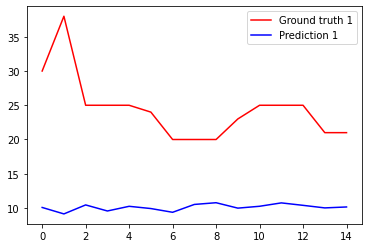

In [13]:
plt.plot(true_cumulative_deaths,c='r', label='Ground truth 1')
plt.plot(predicted_deaths,c='b', label='Prediction 1')
plt.legend()
plt.show()

In [16]:
# test_y_confirmed
print(predicted_confirmed)
print(predicted_deaths)

[11.103058 10.888119 10.820461 11.557693 11.963688 12.339506 11.173883
 11.049365 11.044058 10.50287  12.294484 11.272855 11.797472 11.26147
 10.79454 ]
[10.075412  9.13225  10.446353  9.560891 10.24351   9.916478  9.369393
 10.516228 10.767448  9.976848 10.248412 10.742382 10.384825 10.010299
 10.147015]
